In [16]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import ImageGrid

import cv2
from glob import glob

import tensorflow as tf
import tensorflow.keras as keras
from keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D
from tensorflow.keras.layers import Conv2DTranspose, MaxPooling2D, concatenate, AveragePooling2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [17]:
# https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation

In [18]:
# Set parameters
IMAGE_SIZE = (256, 256)


In [19]:
mask_files = sorted(glob('./brainMRI/lgg-mri-segmentation/kaggle_3m/*/*_mask*')) # i wanna here to be sorted
train_files = [file.replace('_mask', '') for file in mask_files]

In [20]:
def diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    return '1' if value > 0 else '0'
df = pd.DataFrame({"image_path": train_files,
                   "mask_path": mask_files,
                  "diagnosis":[diagnosis(x) for x in mask_files]})
df.head()

image_path  \
0  ./brainMRI/lgg-mri-segmentation/kaggle_3m/TCGA...   
1  ./brainMRI/lgg-mri-segmentation/kaggle_3m/TCGA...   
2  ./brainMRI/lgg-mri-segmentation/kaggle_3m/TCGA...   
3  ./brainMRI/lgg-mri-segmentation/kaggle_3m/TCGA...   
4  ./brainMRI/lgg-mri-segmentation/kaggle_3m/TCGA...   

                                           mask_path diagnosis  
0  ./brainMRI/lgg-mri-segmentation/kaggle_3m/TCGA...         0  
1  ./brainMRI/lgg-mri-segmentation/kaggle_3m/TCGA...         1  
2  ./brainMRI/lgg-mri-segmentation/kaggle_3m/TCGA...         1  
3  ./brainMRI/lgg-mri-segmentation/kaggle_3m/TCGA...         1  
4  ./brainMRI/lgg-mri-segmentation/kaggle_3m/TCGA...         1

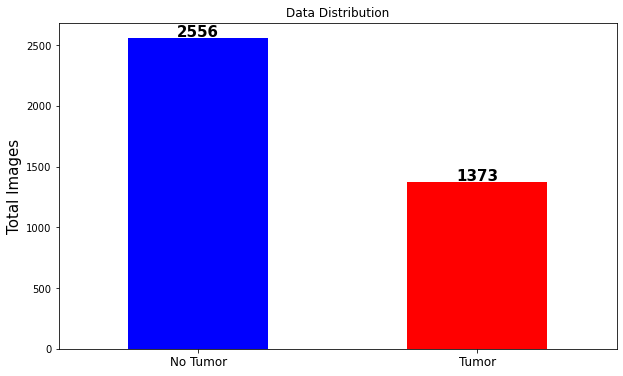

In [21]:
ax = df['diagnosis'].value_counts().plot(kind='bar', stacked=True, figsize=(10,6), color=['blue', 'red'])
ax.set_title('Data Distribution')
ax.set_ylabel('Total Images', fontsize=15)
ax.set_xticklabels(['No Tumor', 'Tumor'], fontsize=12, rotation=0)
for i, rows in enumerate(df['diagnosis'].value_counts().values):
    ax.annotate(int(rows), xy=(i, rows+12), ha='center', fontweight='bold', fontsize=15)

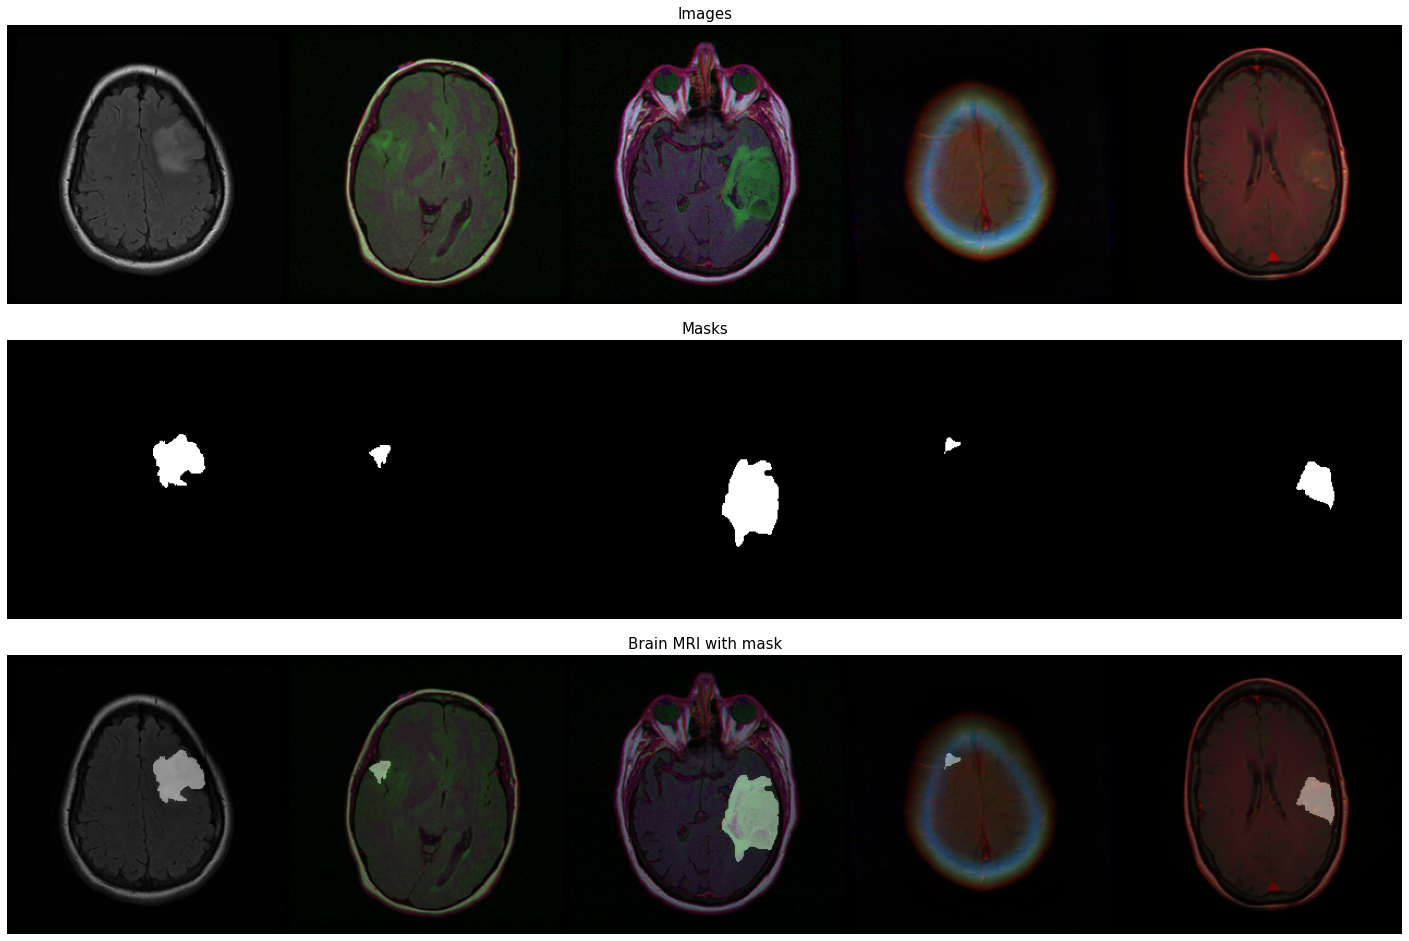

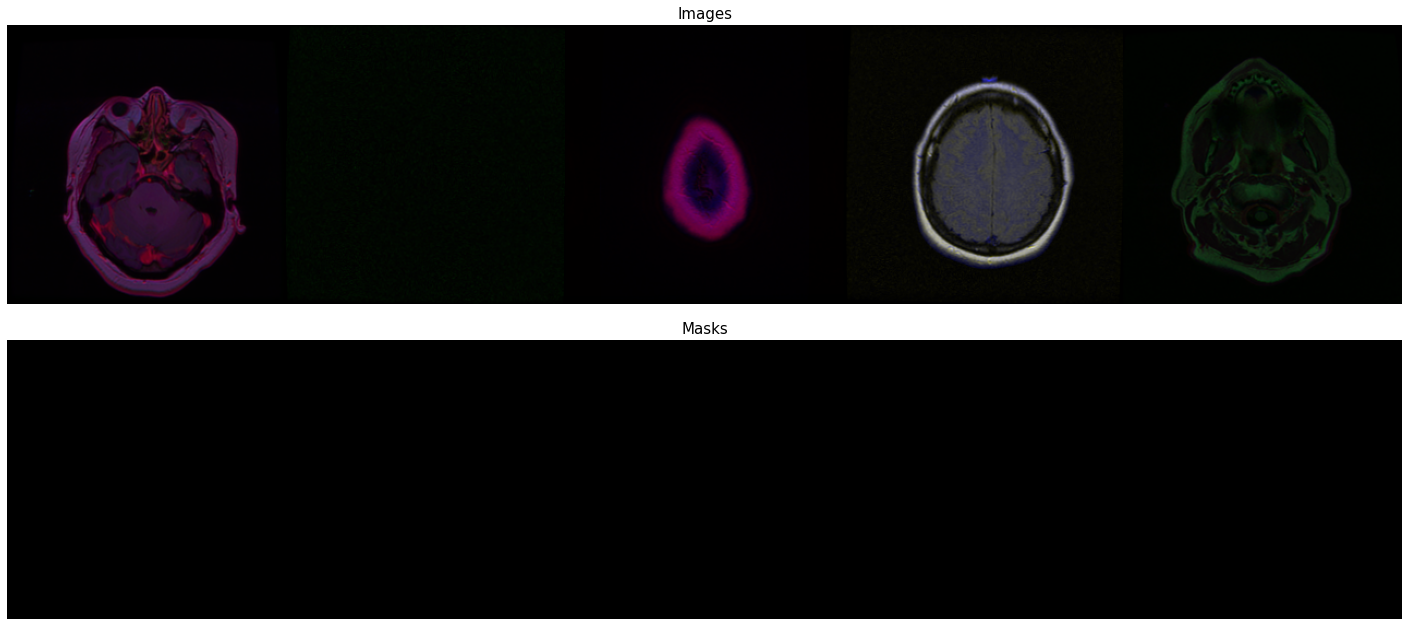

In [22]:
df_positive = df[df['diagnosis']=='1'].sample(5).values
df_negative = df[df['diagnosis']=='0'].sample(5).values

def show_data(df, positive=True):
    images = []
    masks = []
    for data in df:
        img = cv2.imread(data[0])
        mask = cv2.imread(data[1])
        images.append(img)
        masks.append(mask)
    images = np.hstack(np.array(images))
    masks = np.hstack(np.array(masks))
    
    fig = plt.figure(figsize=(25,25))
    if positive:
        grid = ImageGrid(fig, 111, nrows_ncols=(3,1), axes_pad=0.5)
    else:
        grid = ImageGrid(fig, 111, nrows_ncols=(2,1), axes_pad=0.5)
    grid[0].imshow(images)
    grid[0].set_title('Images', fontsize=15)
    grid[0].axis('off')
    grid[1].imshow(masks)
    grid[1].set_title('Masks', fontsize=15)
    grid[1].axis('off')
    if positive:
        grid[2].imshow(images)
        grid[2].imshow(masks, alpha=0.4)
        grid[2].set_title('Brain MRI with mask', fontsize=15)
        grid[2].axis('off')
        
show_data(df_positive)
show_data(df_negative, positive=False)

In [23]:


from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.15)
df_train, df_val = train_test_split(df_train, test_size=0.15)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)



(2838, 3)
(501, 3)
(590, 3)


In [24]:

def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "image_path",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask_path",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255.
    mask = mask / 255.
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)



In [25]:
smooth=1.

def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return dice_coef_loss(y_true, y_pred) + bce(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [26]:
def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

In [27]:
# Set parameters
EPOCHS = 50
BATCH_SIZE = 32
learning_rate = 1e-4

In [21]:
train_generator_args = dict(rotation_range=0.1,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=IMAGE_SIZE)
    
val_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=IMAGE_SIZE)
    
model = unet(input_size=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))



opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)
model.compile(optimizer=opt, loss=bce_dice_loss, metrics=[iou, dice_coef])



filename='Unet1.csv'

callbacks = [ModelCheckpoint('unet_brainMRI_seg.hdf5', verbose=0, save_best_only=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-11),
            EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=15), tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)]

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = val_gen,
                    validation_steps=len(df_val) / BATCH_SIZE)

Found 2838 validated image filenames.
Found 2838 validated image filenames.
Epoch 1/50
89/88 [==============================] - ETA: 0s - loss: 1.2532 - iou: 0.0297 - dice_coef: 0.0574Found 501 validated image filenames.
Found 501 validated image filenames.
88/88 [==============================] - 66s 719ms/step - loss: 1.2532 - iou: 0.0297 - dice_coef: 0.0574 - val_loss: 1.5656 - val_iou: 0.0091 - val_dice_coef: 0.0180 - lr: 1.0000e-04
Epoch 2/50
88/88 [==============================] - 62s 704ms/step - loss: 1.0412 - iou: 0.0538 - dice_coef: 0.1014 - val_loss: 1.3355 - val_iou: 0.0099 - val_dice_coef: 0.0196 - lr: 1.0000e-04
Epoch 3/50
88/88 [==============================] - 62s 699ms/step - loss: 0.9843 - iou: 0.0718 - dice_coef: 0.1331 - val_loss: 1.1483 - val_iou: 0.0111 - val_dice_coef: 0.0219 - lr: 1.0000e-04
Epoch 4/50
88/88 [==============================] - 62s 702ms/step - loss: 0.9319 - iou: 0.0910 - dice_coef: 0.1655 - val_loss: 1.0618 - val_iou: 0.0221 - val_dice_coef: 0

Epoch 41/50
88/88 [==============================] - 61s 691ms/step - loss: 0.1885 - iou: 0.7109 - dice_coef: 0.8256 - val_loss: 0.2155 - val_iou: 0.6694 - val_dice_coef: 0.7994 - lr: 1.0000e-05
Epoch 42/50
88/88 [==============================] - 61s 692ms/step - loss: 0.1868 - iou: 0.7133 - dice_coef: 0.8276 - val_loss: 0.2018 - val_iou: 0.6880 - val_dice_coef: 0.8124 - lr: 1.0000e-05
Epoch 43/50
88/88 [==============================] - 61s 692ms/step - loss: 0.1884 - iou: 0.7128 - dice_coef: 0.8261 - val_loss: 0.1863 - val_iou: 0.7063 - val_dice_coef: 0.8262 - lr: 1.0000e-05
Epoch 44/50
88/88 [==============================] - 61s 690ms/step - loss: 1.0718 - iou: 0.0197 - dice_coef: 0.0378 - val_loss: 0.3058 - val_iou: 0.5583 - val_dice_coef: 0.7129 - lr: 1.0000e-05
Epoch 45/50
88/88 [==============================] - 60s 684ms/step - loss: 0.1986 - iou: 0.6959 - dice_coef: 0.8144 - val_loss: 0.1971 - val_iou: 0.6886 - val_dice_coef: 0.8141 - lr: 1.0000e-05
Epoch 46/50
88/88 [======

Text(0.5, 1.0, 'Dice Coef')

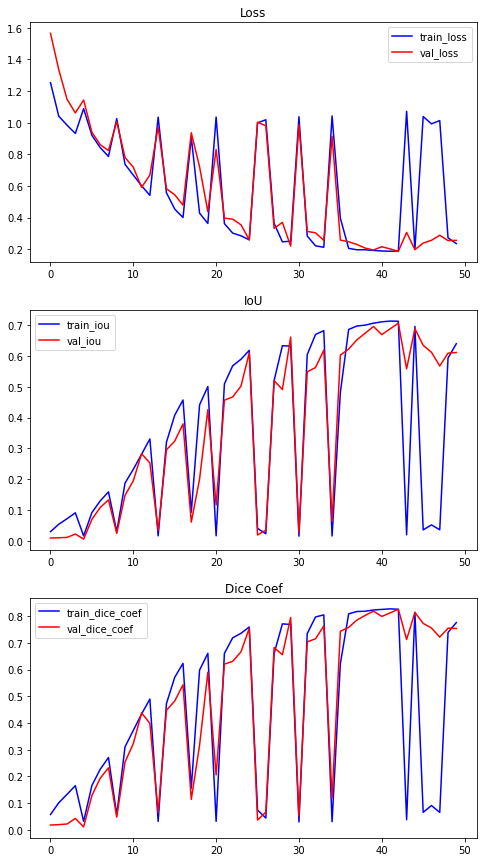

In [22]:
plt.figure(figsize=(8,15))
plt.subplot(3,1,1)
plt.plot(history.history['loss'], 'b-', label='train_loss')
plt.plot(history.history['val_loss'], 'r-', label='val_loss')
plt.legend(loc='best')
plt.title('Loss')

plt.subplot(3,1,2)
plt.plot(history.history['iou'], 'b-', label='train_iou')
plt.plot(history.history['val_iou'], 'r-', label='val_iou')
plt.legend(loc='best')
plt.title('IoU')

plt.subplot(3,1,3)
plt.plot(history.history['dice_coef'], 'b-', label='train_dice_coef')
plt.plot(history.history['val_dice_coef'], 'r-', label='val_dice_coef')
plt.legend(loc='best')
plt.title('Dice Coef')

In [23]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=IMAGE_SIZE)
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

Found 590 validated image filenames.
Found 590 validated image filenames.
18/18 [==============================] - 3s 168ms/step - loss: 0.2125 - iou: 0.6646 - dice_coef: 0.7967
Test IOU:  0.6645681858062744
Test Dice Coefficent:  0.7966835498809814


Attempt 2

In [28]:
train_generator_args = dict(rotation_range=0.1,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=IMAGE_SIZE)
    
val_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=IMAGE_SIZE)
    
model = unet(input_size=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))



opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)
model.compile(optimizer=opt, loss=bce_dice_loss, metrics=[iou, dice_coef])



filename='UnetGG.csv'

callbacks = [ModelCheckpoint('unet_brainMRI_seg.hdf5', verbose=0, save_best_only=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-11),
            EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=15), tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)]

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = val_gen,
                    validation_steps=len(df_val) / BATCH_SIZE)

/mnt/home/minshang/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Found 2838 validated image filenames.
Found 2838 validated image filenames.
Epoch 1/50


/mnt/home/minshang/anaconda3/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


89/88 [==============================] - ETA: 0s - loss: 1.4228 - iou: 0.0222 - dice_coef: 0.0432Found 501 validated image filenames.
Found 501 validated image filenames.
88/88 [==============================] - 45s 495ms/step - loss: 1.4228 - iou: 0.0222 - dice_coef: 0.0432 - val_loss: 1.5828 - val_iou: 0.0089 - val_dice_coef: 0.0176 - lr: 1.0000e-04
Epoch 2/50
88/88 [==============================] - 44s 494ms/step - loss: 1.1358 - iou: 0.0394 - dice_coef: 0.0757 - val_loss: 1.3674 - val_iou: 0.0088 - val_dice_coef: 0.0173 - lr: 1.0000e-04
Epoch 3/50
88/88 [==============================] - 44s 501ms/step - loss: 1.0914 - iou: 0.0474 - dice_coef: 0.0900 - val_loss: 1.1817 - val_iou: 0.0073 - val_dice_coef: 0.0145 - lr: 1.0000e-04
Epoch 4/50
88/88 [==============================] - 43s 485ms/step - loss: 1.0428 - iou: 0.0586 - dice_coef: 0.1101 - val_loss: 1.1257 - val_iou: 0.0095 - val_dice_coef: 0.0187 - lr: 1.0000e-04
Epoch 5/50
88/88 [==============================] - 44s 495ms/st

88/88 [==============================] - 44s 498ms/step - loss: 0.1694 - iou: 0.7351 - dice_coef: 0.8446 - val_loss: 0.1642 - val_iou: 0.7374 - val_dice_coef: 0.8475 - lr: 1.0000e-04
Epoch 43/50
88/88 [==============================] - 43s 490ms/step - loss: 0.1641 - iou: 0.7426 - dice_coef: 0.8497 - val_loss: 0.2297 - val_iou: 0.6560 - val_dice_coef: 0.7869 - lr: 1.0000e-04
Epoch 44/50
88/88 [==============================] - 43s 486ms/step - loss: 0.1777 - iou: 0.7250 - dice_coef: 0.8372 - val_loss: 0.2007 - val_iou: 0.6922 - val_dice_coef: 0.8158 - lr: 1.0000e-04
Epoch 45/50
88/88 [==============================] - 44s 494ms/step - loss: 0.1477 - iou: 0.7648 - dice_coef: 0.8649 - val_loss: 0.1473 - val_iou: 0.7593 - val_dice_coef: 0.8612 - lr: 1.0000e-04
Epoch 46/50
88/88 [==============================] - 43s 488ms/step - loss: 0.1456 - iou: 0.7695 - dice_coef: 0.8666 - val_loss: 0.1544 - val_iou: 0.7514 - val_dice_coef: 0.8564 - lr: 1.0000e-04
Epoch 47/50
88/88 [==================

Text(0.5, 1.0, 'Dice Coef')

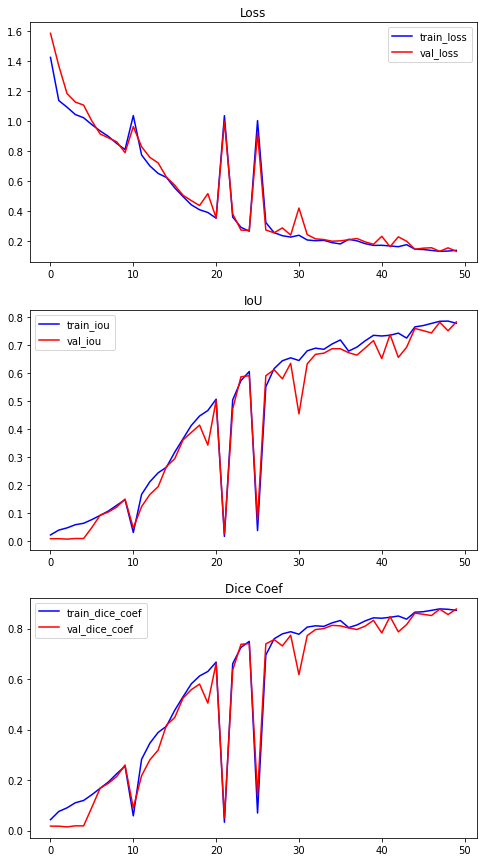

In [29]:
plt.figure(figsize=(8,15))
plt.subplot(3,1,1)
plt.plot(history.history['loss'], 'b-', label='train_loss')
plt.plot(history.history['val_loss'], 'r-', label='val_loss')
plt.legend(loc='best')
plt.title('Loss')

plt.subplot(3,1,2)
plt.plot(history.history['iou'], 'b-', label='train_iou')
plt.plot(history.history['val_iou'], 'r-', label='val_iou')
plt.legend(loc='best')
plt.title('IoU')

plt.subplot(3,1,3)
plt.plot(history.history['dice_coef'], 'b-', label='train_dice_coef')
plt.plot(history.history['val_dice_coef'], 'r-', label='val_dice_coef')
plt.legend(loc='best')
plt.title('Dice Coef')

In [30]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=IMAGE_SIZE)
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

Found 590 validated image filenames.
Found 590 validated image filenames.
18/18 [==============================] - 3s 143ms/step - loss: 0.1599 - iou: 0.7462 - dice_coef: 0.8521
Test IOU:  0.7462244033813477
Test Dice Coefficent:  0.8520626425743103


1/1 [==============================] - 1s 1s/step


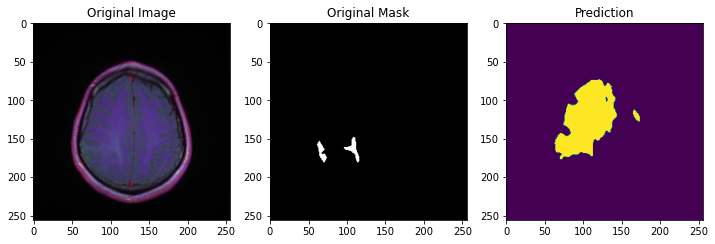

1/1 [==============================] - 0s 29ms/step


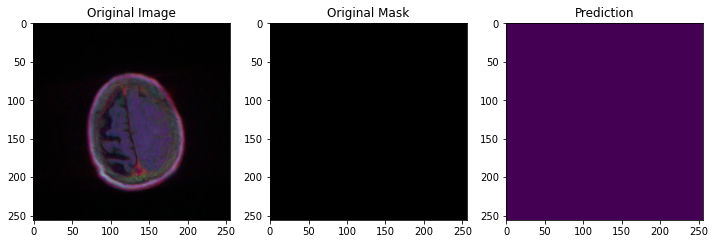

1/1 [==============================] - 0s 25ms/step


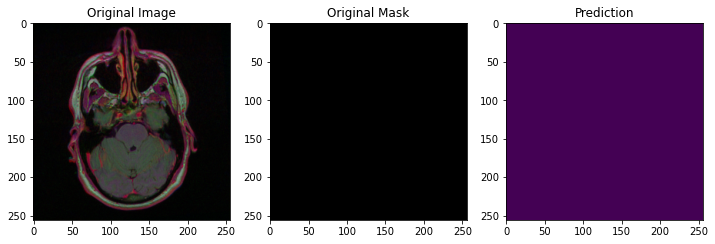

1/1 [==============================] - 0s 25ms/step


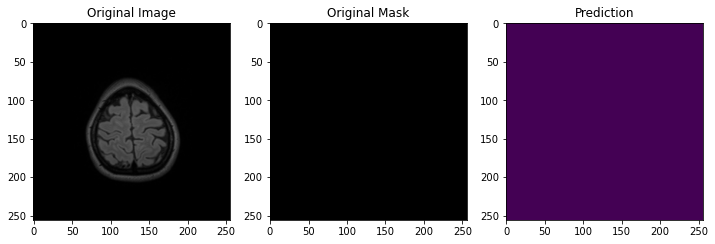

1/1 [==============================] - 0s 28ms/step


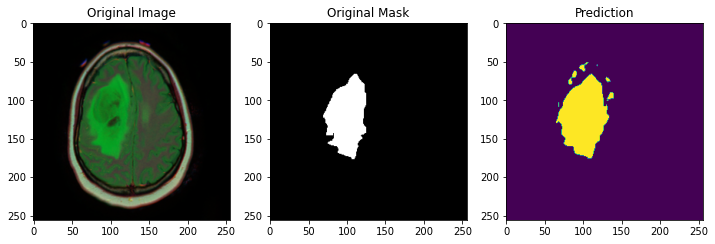

1/1 [==============================] - 0s 28ms/step


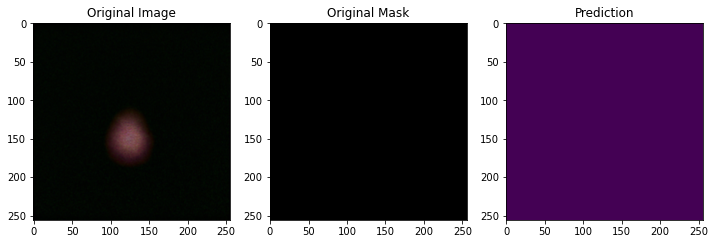

1/1 [==============================] - 0s 28ms/step


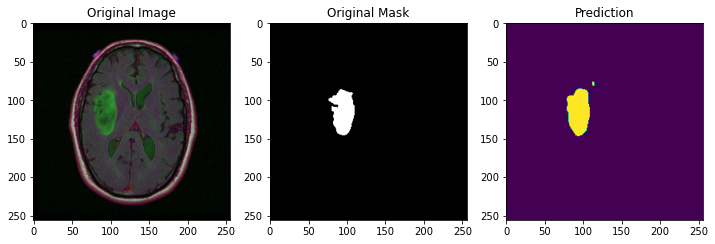

1/1 [==============================] - 0s 26ms/step


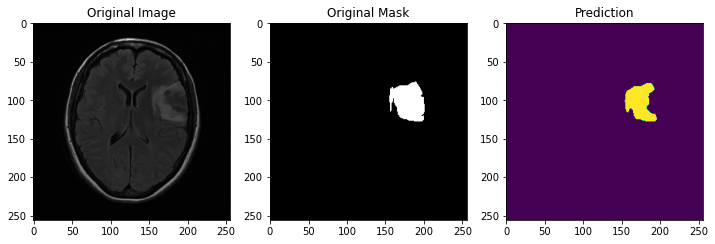

1/1 [==============================] - 0s 24ms/step


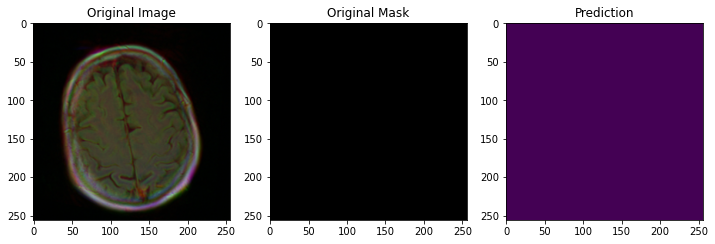

1/1 [==============================] - 0s 21ms/step


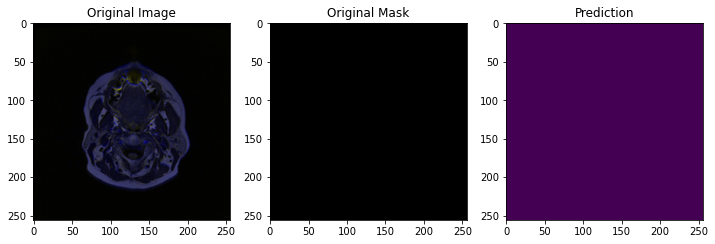

1/1 [==============================] - 0s 26ms/step


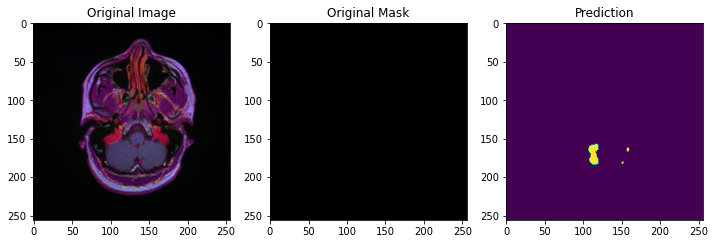

1/1 [==============================] - 0s 26ms/step


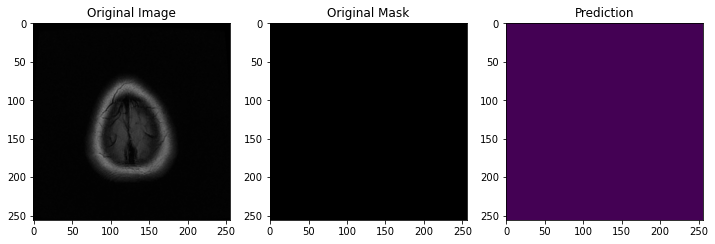

1/1 [==============================] - 0s 22ms/step


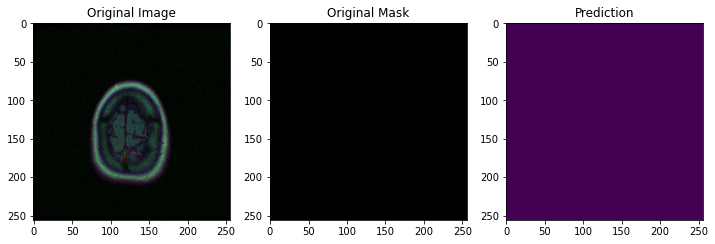

1/1 [==============================] - 0s 25ms/step


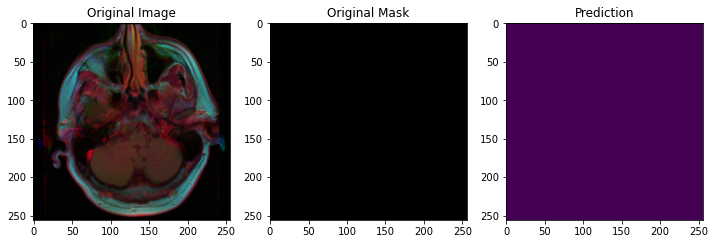

1/1 [==============================] - 0s 24ms/step


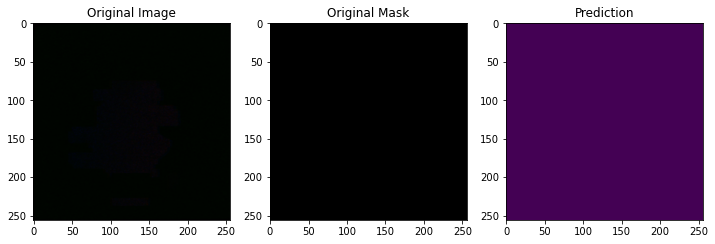

1/1 [==============================] - 0s 31ms/step


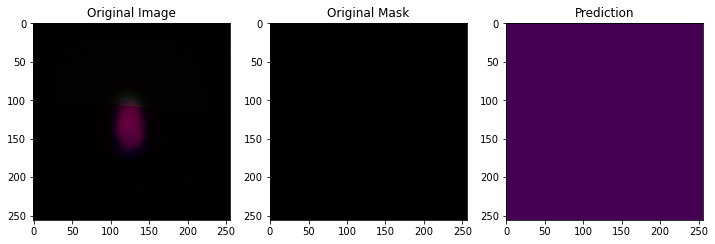

1/1 [==============================] - 0s 22ms/step


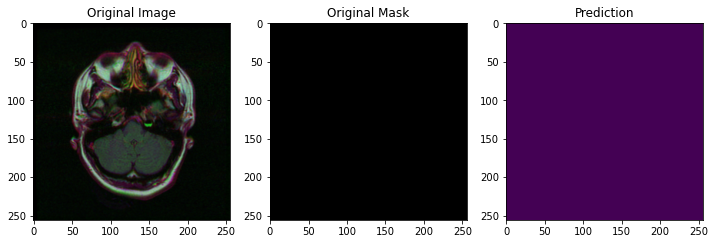

1/1 [==============================] - 0s 29ms/step


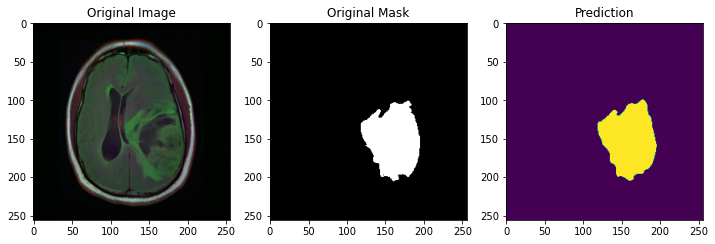

1/1 [==============================] - 0s 28ms/step


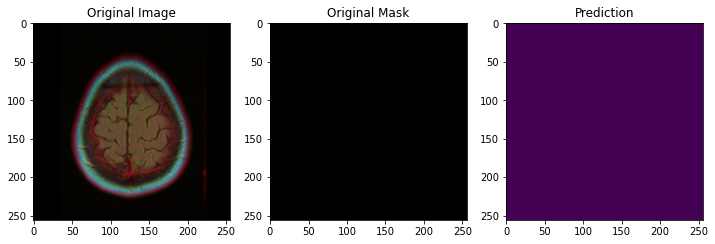

1/1 [==============================] - 0s 26ms/step


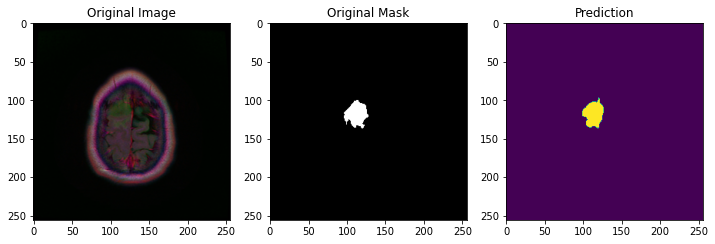

1/1 [==============================] - 0s 27ms/step


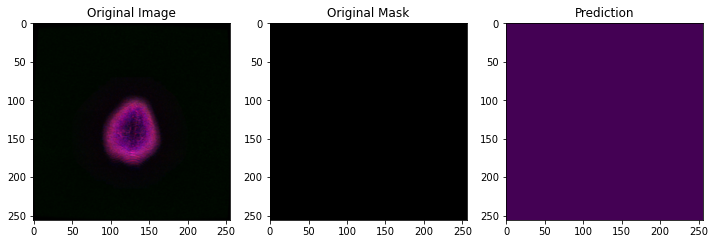

1/1 [==============================] - 0s 30ms/step


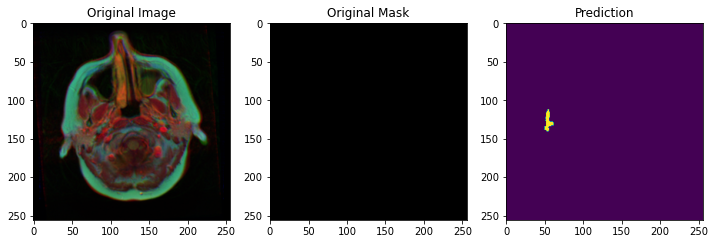

1/1 [==============================] - 0s 30ms/step


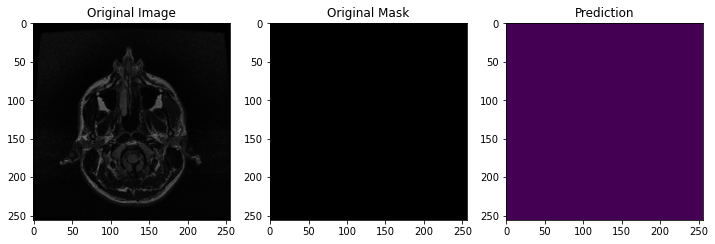

1/1 [==============================] - 0s 26ms/step


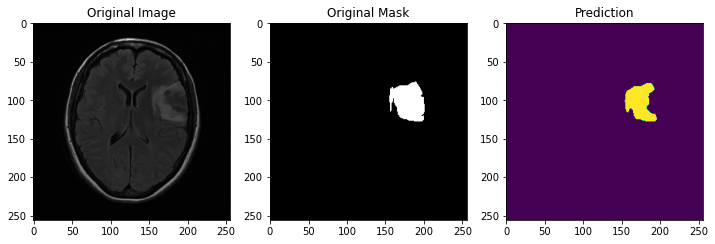

1/1 [==============================] - 0s 26ms/step


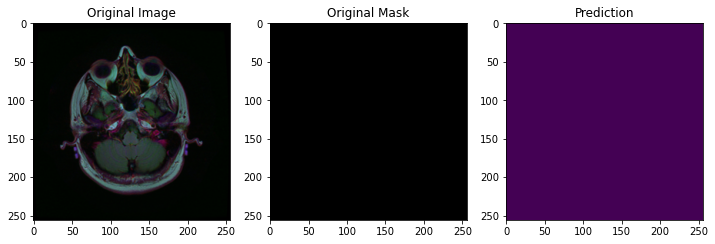

1/1 [==============================] - 0s 28ms/step


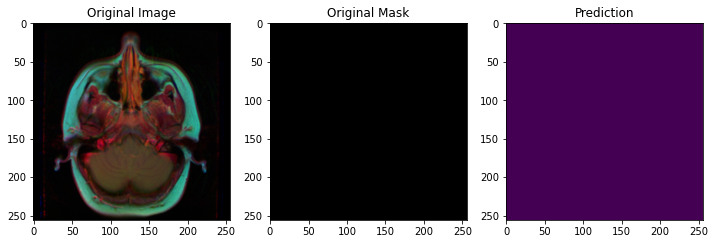

1/1 [==============================] - 0s 25ms/step


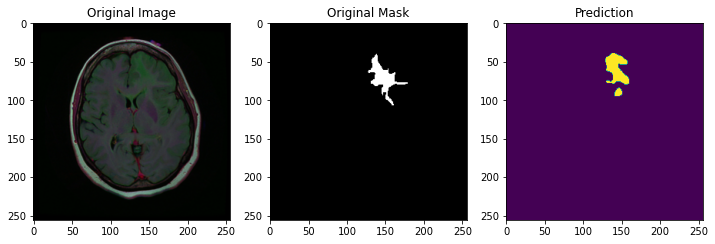

1/1 [==============================] - 0s 24ms/step


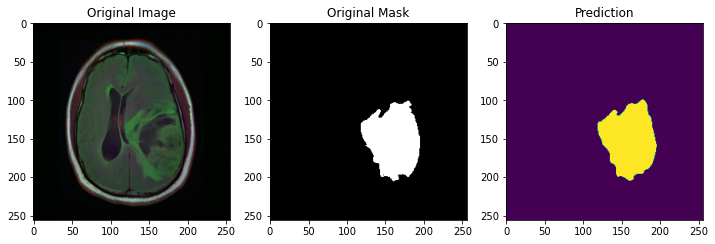

1/1 [==============================] - 0s 26ms/step


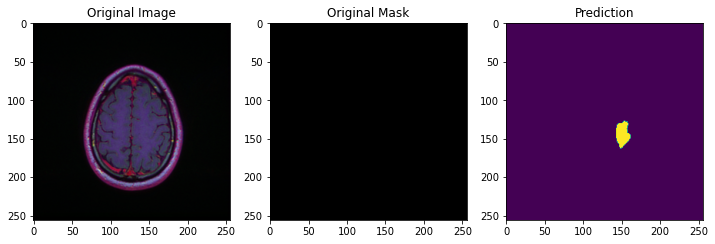

1/1 [==============================] - 0s 29ms/step


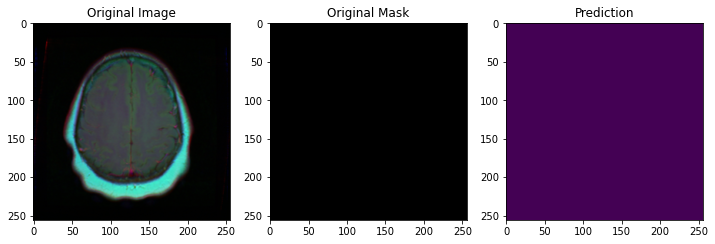

In [24]:

for i in range(30):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['image_path'].iloc[index])
    img = cv2.resize(img ,IMAGE_SIZE)
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask_path'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()


# FINs Training

In [9]:
df_train.values

array([['./brainMRI/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_2.tif',
        './brainMRI/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_2_mask.tif',
        '0'],
       ['./brainMRI/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_13.tif',
        './brainMRI/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_13_mask.tif',
        '0'],
       ['./brainMRI/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_27.tif',
        './brainMRI/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_27_mask.tif',
        '1'],
       ...,
       ['./brainMRI/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_5.tif',
        './brainMRI/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_5_mask.tif',
        '0'],
       ['./brainMRI/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_539

In [10]:
np.save('df_train.values',df_train.values)

In [9]:
df_train.values

array([['./brainMRI/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_7.tif',
        './brainMRI/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_7_mask.tif',
        '0'],
       ['./brainMRI/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_33.tif',
        './brainMRI/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_33_mask.tif',
        '0'],
       ['./brainMRI/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_46.tif',
        './brainMRI/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_46_mask.tif',
        '0'],
       ...,
       ['./brainMRI/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_83.tif',
        './brainMRI/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_83_mask.tif',
        '0'],
       ['./brainMRI/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7

In [9]:
df_train.values[0][0]

'./brainMRI/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_7.tif'

In [11]:
import radiomics
from radiomics.featureextractor import RadiomicsFeatureExtractor
import SimpleITK as sitk

In [12]:
# convert rgb to grayscale

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def LoadDataFromImages(files):
    input_array = []
    #output_array=[]
    o1=[]
    o2=[]
    o3=[]
    o4=[]
    o5=[]
    o6= []
    n= 0

    extractor = RadiomicsFeatureExtractor()
    # Disable all classes except firstorder
    extractor.disableAllFeatures()
    extractor.enableFeaturesByName(firstorder=['Skewness'])  # change here to extract
#     extractor.enableFeaturesByName(glcm=['Autocorrelation'])
    extractor.enableFeaturesByName(glrlm=['GrayLevelVariance'])
#     extractor.enableFeaturesByName(glszm=['SizeZoneNonUniformity'])

    extractor.enableFeaturesByName(glcm=['Autocorrelation','ClusterShade','DifferenceEntropy'])  # change here to extract
   # extractor.enableFeaturesByName(firstorder=['Energy'])
    extractor.enableFeaturesByName(glszm=['SizeZoneNonUniformity'])
    

    for i in files:
        
        feature_clustershade_smallparts = []
        feature_skew = []
        feature_glv = []
        feature_autoco = []
        feature_DE = []
        feature_SZNU =[]
        
        #print(files[0])
        im = sitk.ReadImage(i[0])
        input_array.append(sitk.GetArrayFromImage(im))

        im_array = sitk.GetArrayFromImage(im)
        im_array = rgb2gray(im_array)
        

        im_array = im_array.reshape(256,16,16,1)

        for j in im_array:
            ima = sitk.GetImageFromArray(j)
            
            #print(ima.GetSize())

            ma_arr = np.ones(ima.GetSize()[::-1])  # reverse the order as image is xyz, array is zyx
            ma = sitk.GetImageFromArray(ma_arr)
            ma.CopyInformation(ima)  # Copy geometric info

        # extract features and fill the output array
            features = extractor.execute(ima, ma)
            #print(features['original_glcm_ClusterShade'])
            feature_clustershade_smallparts.append(features['original_glcm_ClusterShade'])
            feature_skew.append(features['original_firstorder_Skewness'])
            feature_glv.append(features['original_glrlm_GrayLevelVariance'])
            feature_autoco.append(features['original_glcm_Autocorrelation'])
            feature_DE.append(features['original_glcm_DifferenceEntropy'])
            feature_SZNU.append(features['original_glszm_SizeZoneNonUniformity'])
            
            n +=1
            print(n)

        o1.append(feature_clustershade_smallparts)  # change here to extract
        o2.append(feature_skew)
        o3.append(feature_glv)
        o4.append(feature_autoco)
        o5.append(feature_DE)
        o6.append(feature_SZNU)


            
    return input_array, o1 ,o2,o3,o4,o5,o6

In [11]:
# inn ,o1,o2,o3,o4,o5,o6 = LoadDataFromImages(df_train.values)

In [16]:
inn = np.array(inn)
o1 = np.array(o1)
o2 = np.array(o2)
o3 = np.array(o3)
o4 = np.array(o4)
o5 = np.array(o5)
o6 = np.array(o6)

In [2]:
# np.save("briin.npy",inn)
# np.save("brio1.npy",o1)
# np.save("brio2.npy",o2)
# np.save("brio3.npy",o3)
# np.save("brio4.npy",o4)
# np.save("brio5.npy",o5)
# np.save("brio6.npy",o6)

In [10]:
inn = np.load('briin.npy')
o1 =  np.load("brio1.npy")
o2 =  np.load("brio2.npy")
o3 =  np.load("brio3.npy")
o4 =  np.load("brio4.npy")
o5 =  np.load("brio5.npy")
o6 =  np.load("brio6.npy")

In [12]:
inn = np.array(inn)
o1 = np.array(o1).reshape(2838,256,1)
o2 = np.array(o2).reshape(2838,256,1)
o3 = np.array(o3).reshape(2838,256,1)
o4 = np.array(o4).reshape(2838,256,1)
o5 = np.array(o5).reshape(2838,256,1)
o6 = np.array(o6).reshape(2838,256,1)

In [13]:
inn.shape

(2838, 256, 256, 3)

In [14]:
o1.shape

(2838, 256, 1)

In [51]:
def MakeModel(modelname):
    input_layer = keras.Input(shape=(256,256,3))
    x = Flatten()(input_layer)
    #x = BatchNormalization(axis=1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)



    out = Dense(256, activation = 'linear', name= modelname)(x)

    model = keras.Model(input_layer, out, name= modelname)
    
    return model

In [52]:
model = MakeModel('SZNU')

In [53]:
model.compile(optimizer=tf.keras.optimizers.Adam(
 learning_rate= 0.0001
), loss="mse", metrics='mae')

In [55]:
model.fit(inn, o6, 
              epochs=30, 
          batch_size=64,
                shuffle=True
            )

Epoch 1/30
45/45 [==============================] - 1s 15ms/step - loss: 4.0034 - mae: 1.3906
Epoch 2/30
45/45 [==============================] - 1s 15ms/step - loss: 3.9553 - mae: 1.3828
Epoch 3/30
45/45 [==============================] - 1s 15ms/step - loss: 3.8168 - mae: 1.3549
Epoch 4/30
45/45 [==============================] - 1s 15ms/step - loss: 3.8039 - mae: 1.3527
Epoch 5/30
45/45 [==============================] - 1s 15ms/step - loss: 3.8030 - mae: 1.3524
Epoch 6/30
45/45 [==============================] - 1s 15ms/step - loss: 3.9147 - mae: 1.3746
Epoch 7/30
45/45 [==============================] - 1s 14ms/step - loss: 3.7812 - mae: 1.3497
Epoch 8/30
45/45 [==============================] - 1s 15ms/step - loss: 3.6907 - mae: 1.3319
Epoch 9/30
45/45 [==============================] - 1s 15ms/step - loss: 3.6195 - mae: 1.3168
Epoch 10/30
45/45 [==============================] - 1s 15ms/step - loss: 3.6457 - mae: 1.3222
Epoch 11/30
45/45 [==============================] - 1s 15m

In [56]:
model.save('briSZNU.h5')

In [57]:
model.predict(inn)

89/89 [==============================] - 1s 6ms/step


array([[0.30060303, 0.14290452, 0.22563267, ..., 0.31073642, 0.3495952 ,
        0.20532003],
       [0.4451586 , 0.57509613, 1.4250566 , ..., 1.1329025 , 0.62431896,
        0.20837072],
       [0.63947695, 0.5225059 , 0.95113933, ..., 0.25586867, 0.40671778,
        0.25991434],
       ...,
       [1.612779  , 1.2889355 , 1.376659  , ..., 1.21452   , 1.0502073 ,
        1.2873571 ],
       [1.8594579 , 0.9528972 , 1.6787465 , ..., 1.02738   , 1.2773074 ,
        1.0075572 ],
       [1.1678675 , 1.0398067 , 0.70727384, ..., 0.30072826, 0.91395295,
        0.34091493]], dtype=float32)

In [24]:
o1.shape

(5, 1024, 1)

In [31]:
m1 = load_model('briCS.h5')
m2 = load_model('briSkew.h5')
m3 = load_model('briGrayLevelVariance.h5')
m4 = load_model('briAuto.h5')
m5 = load_model('briDE.h5')
m6 = load_model('briSZNU.h5')

def unetFIN(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    l1 = m1(inputs)
    l2 = m2(inputs)
    l3 = m3(inputs)
    l4 = m4(inputs)
    l5 = m5(inputs)
    l6 = m6(inputs)
    

    
    
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)
    
    l1 =  layers.Reshape([16,16,1])(l1)
    l2 =  layers.Reshape([16,16,1])(l2)
    l3 =  layers.Reshape([16,16,1])(l3)
    l4 =  layers.Reshape([16,16,1])(l4)
    l5 =  layers.Reshape([16,16,1])(l5)
    l6 =  layers.Reshape([16,16,1])(l6)
    
    
    sample = tf.keras.layers.UpSampling2D(size=(8,8))(l1)
    sample2 = tf.keras.layers.UpSampling2D(size=(8,8))(l2)
    sample3 = tf.keras.layers.UpSampling2D(size=(8,8))(l3)
    sample4 = tf.keras.layers.UpSampling2D(size=(8,8))(l4)
    sample5 = tf.keras.layers.UpSampling2D(size=(8,8))(l5)
    sample6 = tf.keras.layers.UpSampling2D(size=(8,8))(l6)

    #flattenplace =  Flatten()(pool1)
    poolcon = concatenate([sample,sample2,sample3,sample4, sample5, sample6, pool1])
    #poolcon = layers.Reshape((100,100))
    #output = Conv2D(64, (3, 3), padding='same')(poolcon)
    #output = Reshape((100,100))(output)
    #output = layers.Dense(10*100, activation='sigmoid')(poolcon)
    output = layers.Reshape([128,128,70])(poolcon)


    conv2 = Conv2D(128, (3, 3), padding='same')(output)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)
    
#     flattenplace = Flatten()(bn9)
#     flattenplace2 = Flatten()(l1)
#     poolcon = concatenate([flattenplace,flattenplace2])
#     out = Conv2D(1, (1, 1), activation = 'sigmoid')(poolcon)

    return Model(inputs=[inputs], outputs=[conv10])

In [32]:
# Set parameters
EPOCHS = 50
BATCH_SIZE = 32
learning_rate = 1e-4

In [13]:
train_generator_args = dict(rotation_range=0.1,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=IMAGE_SIZE)
    
val_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=IMAGE_SIZE)
    
model = unetFIN(input_size=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))



opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)
model.compile(optimizer=opt, loss=bce_dice_loss, metrics=[iou, dice_coef])



filename='UnetFINs.csv'

callbacks = [
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-11),
            EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=15), tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)]

historyFIN = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = val_gen,
                    validation_steps=len(df_val) / BATCH_SIZE)

/mnt/home/minshang/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Found 2838 validated image filenames.
Found 2838 validated image filenames.
Epoch 1/50


/mnt/home/minshang/anaconda3/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
2022-09-04 22:10:39.677103: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


89/88 [==============================] - ETA: 0s - loss: 1.1898 - iou: 0.0362 - dice_coef: 0.0691Found 501 validated image filenames.
Found 501 validated image filenames.
88/88 [==============================] - 98s 947ms/step - loss: 1.1898 - iou: 0.0362 - dice_coef: 0.0691 - val_loss: 1.5753 - val_iou: 0.0093 - val_dice_coef: 0.0185 - lr: 1.0000e-04
Epoch 2/50
88/88 [==============================] - 63s 717ms/step - loss: 0.9670 - iou: 0.0766 - dice_coef: 0.1412 - val_loss: 1.3465 - val_iou: 0.0110 - val_dice_coef: 0.0217 - lr: 1.0000e-04
Epoch 3/50
88/88 [==============================] - 62s 702ms/step - loss: 0.9034 - iou: 0.1020 - dice_coef: 0.1834 - val_loss: 1.2253 - val_iou: 0.0242 - val_dice_coef: 0.0471 - lr: 1.0000e-04
Epoch 4/50
88/88 [==============================] - 61s 693ms/step - loss: 0.8428 - iou: 0.1299 - dice_coef: 0.2278 - val_loss: 1.0323 - val_iou: 0.0259 - val_dice_coef: 0.0498 - lr: 1.0000e-04
Epoch 5/50
88/88 [==============================] - 61s 689ms/st

Text(0.5, 1.0, 'Dice Coef')

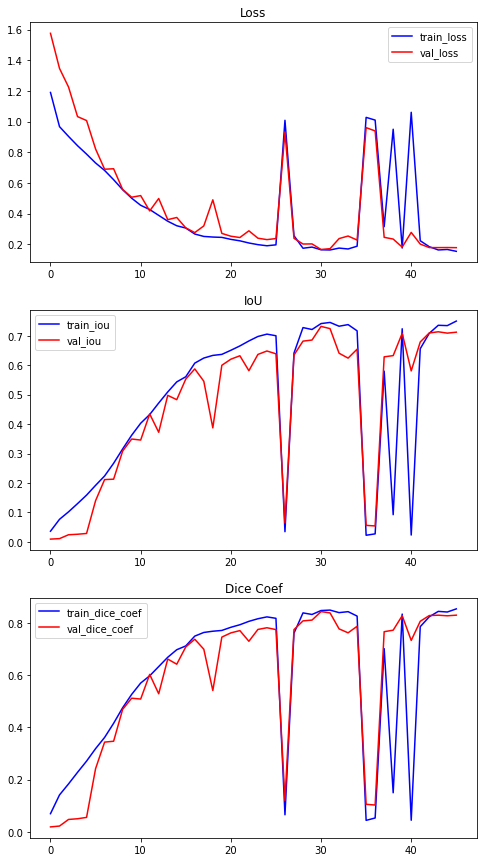

In [15]:
plt.figure(figsize=(8,15))
plt.subplot(3,1,1)
plt.plot(historyFIN.history['loss'], 'b-', label='train_loss')
plt.plot(historyFIN.history['val_loss'], 'r-', label='val_loss')
plt.legend(loc='best')
plt.title('Loss')

plt.subplot(3,1,2)
plt.plot(historyFIN.history['iou'], 'b-', label='train_iou')
plt.plot(historyFIN.history['val_iou'], 'r-', label='val_iou')
plt.legend(loc='best')
plt.title('IoU')

plt.subplot(3,1,3)
plt.plot(historyFIN.history['dice_coef'], 'b-', label='train_dice_coef')
plt.plot(historyFIN.history['val_dice_coef'], 'r-', label='val_dice_coef')
plt.legend(loc='best')
plt.title('Dice Coef')

In [16]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=IMAGE_SIZE)
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

Found 590 validated image filenames.
Found 590 validated image filenames.
18/18 [==============================] - 7s 393ms/step - loss: 0.1520 - iou: 0.7568 - dice_coef: 0.8601
Test IOU:  0.7568245530128479
Test Dice Coefficent:  0.8600544929504395


Attemp2

In [ ]:
train_generator_args = dict(rotation_range=0.1,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=IMAGE_SIZE)
    
val_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=IMAGE_SIZE)
    
model = unetFIN(input_size=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))



opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)
model.compile(optimizer=opt, loss=bce_dice_loss, metrics=[iou, dice_coef])



filename='UnetFINsGG.csv'

callbacks = [
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-11),
            EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=15), tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)]

historyFIN = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = val_gen,
                    validation_steps=len(df_val) / BATCH_SIZE)

Found 2838 validated image filenames.
Found 2838 validated image filenames.
Epoch 1/50
89/88 [==============================] - ETA: 0s - loss: 1.2130 - iou: 0.0386 - dice_coef: 0.0733Found 501 validated image filenames.
Found 501 validated image filenames.
88/88 [==============================] - 49s 514ms/step - loss: 1.2130 - iou: 0.0386 - dice_coef: 0.0733 - val_loss: 1.5567 - val_iou: 0.0102 - val_dice_coef: 0.0202 - lr: 1.0000e-04
Epoch 2/50
88/88 [==============================] - 44s 497ms/step - loss: 0.9684 - iou: 0.0785 - dice_coef: 0.1447 - val_loss: 1.3025 - val_iou: 0.0119 - val_dice_coef: 0.0235 - lr: 1.0000e-04
Epoch 3/50
88/88 [==============================] - 44s 499ms/step - loss: 0.9048 - iou: 0.1028 - dice_coef: 0.1851 - val_loss: 1.1364 - val_iou: 0.0082 - val_dice_coef: 0.0162 - lr: 1.0000e-04
Epoch 4/50
88/88 [==============================] - 44s 497ms/step - loss: 0.8528 - iou: 0.1259 - dice_coef: 0.2216 - val_loss: 1.0455 - val_iou: 0.0215 - val_dice_coef: 0

In [ ]:
plt.figure(figsize=(8,15))
plt.subplot(3,1,1)
plt.plot(historyFIN.history['loss'], 'b-', label='train_loss')
plt.plot(historyFIN.history['val_loss'], 'r-', label='val_loss')
plt.legend(loc='best')
plt.title('Loss')

plt.subplot(3,1,2)
plt.plot(historyFIN.history['iou'], 'b-', label='train_iou')
plt.plot(historyFIN.history['val_iou'], 'r-', label='val_iou')
plt.legend(loc='best')
plt.title('IoU')

plt.subplot(3,1,3)
plt.plot(historyFIN.history['dice_coef'], 'b-', label='train_dice_coef')
plt.plot(historyFIN.history['val_dice_coef'], 'r-', label='val_dice_coef')
plt.legend(loc='best')
plt.title('Dice Coef')

In [ ]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=IMAGE_SIZE)
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])